# Sparkify Exploratory Data Analysis (EDA)
#### This notebook contains all the EDA which is later used in modelling in sparkify.ipynb 

## 1.0 Import libraries and start the session.

In [88]:
import findspark
findspark.init()

In [89]:
# import libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf,count\
,when,isnan,regexp_replace,countDistinct,month,from_unixtime,to_timestamp,lead,datediff,mean
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import *
from pyspark.sql.window import Window
import pandas as pd
import numpy as np
import seaborn as sns
import re

%matplotlib inline
import matplotlib.pyplot as plt

In [90]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("EDA") \
    .getOrCreate()

# 2.0 Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [91]:
 #load spark data
df = spark.read.json('mini_sparkify_event_data.json')
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [92]:
df.take(5) #show top 5 rows

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [93]:
pd.DataFrame(df.take(5), columns=df.columns).head() #df can be converted to pandas df for easy visualization


,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [94]:
#checking statistics of the data
df.describe().show() #for easy visualization df.describe(col_name).show()

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

### 2.1 Checking missing/incorrect values

In [95]:
# check number of NAs in each column
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).collect()

[Row(artist=58392, auth=0, firstName=8346, gender=8346, itemInSession=0, lastName=8346, length=58392, level=0, location=8346, method=0, page=0, registration=8346, sessionId=0, song=58392, status=0, ts=0, userAgent=8346, userId=0)]

#### As seen, important columns like userId, sessionId, page,and ts are having no missing values. However, it is important to check if data is of correct type.

In [96]:
#Checking if user id is a number
print(df.select("userId").dropDuplicates().sort("userId").show())
print("Empty user ids are : {}".format(df.filter(df["userId"] == "").count()))


+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows

None
Empty user ids are : 8346


As visible, There are 8346 user Ids which are empty strings.

In [97]:
#remove user ids which are empty strings
df = df.filter(df["userId"] != "")

In [98]:
#checking how many sessionIds are missimng
df.filter(df["sessionId"] != "").count()

0

#### There are no empty strings as session Ids

### 2.2 Timestamp analysis

In [99]:
# change the original timestamp in the dataset to the common format
get_time = udf(lambda x: pd.Timestamp(x / 1000.0,unit='s').strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn("time", get_time(df.ts)).withColumn('registration_time',get_time(df.registration))
df = df.withColumn('date', from_unixtime(col('ts')/1000).cast(DateType()))

In [100]:
#checking the time range of the dataset (to be used in EDA)
df.select('time').describe().show()

+-------+-------------------+
|summary|               time|
+-------+-------------------+
|  count|             278154|
|   mean|               null|
| stddev|               null|
|    min|2018-10-01 00:01:57|
|    max|2018-12-03 01:11:16|
+-------+-------------------+



#### The data is of rougly 2 months i.e from 1st October to 3rd December 2018. 

### 2.3 Individual column analyses

In [101]:
for s in df.schema:    
    if str(s.name) in ['auth','gender','level' ,'location',\
                          'method','page','status']:
        print(df.select(s.name).distinct().show())
    if str(s.name) in ['userId','artist','itemInSession']:
        print("{} count : ".format(s.name), df.select(s.name).distinct().count())
    


artist count :  17656
+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+

None
+------+
|gender|
+------+
|     F|
|     M|
+------+

None
itemInSession count :  1311
+-----+
|level|
+-----+
| free|
| paid|
+-----+

None
+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
|Deltona-Daytona B...|
|San Diego-Carlsba...|
|Cleveland-Elyria, OH|
|Kingsport-Bristol...|
|New Haven-Milford...|
|Birmingham-Hoover...|
|  Corpus Christi, TX|
|         Dubuque, IA|
|Las Vegas-Henders...|
|Indianapolis-Carm...|
|Seattle-Tacoma-Be...|
|          Albany, OR|
|   Winston-Salem, NC|
|     Bakersfield, CA|
|Los Angeles-Long ...|
|Minneapolis-St. P...|
|San Francisco-Oak...|
|Phoenix-Mesa-Scot...|
+--------------------+
only showing top 20 rows

None
+------+
|method|
+------+
|   PUT|
|   GET|
+------+

None
+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|


#### Takeaways -:
1. Location can be changed to include only the city for later comparison of churned users
2. Status indicates HTTP codes - 307: Temporary Redirect, 404: Not Found, 200: OK
3. There are 226 unique users
4. Page where it shows 'Cancellation Confirmation' and auth as 'Cancelled' can indicate churned users.

### 2.4 Understanding how the data is represented

In [102]:
df.where("artist is null").show(5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+-------------------+-------------------+----------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|               time|  registration_time|      date|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+-------------------+-------------------+----------+
|  null|Logged In|    Colin|     M|           54| Freeman|  null| paid|     Bakersfield, CA|   PUT|Add to Playlist|1538173362000|       29|null|   200|1538352905000|Mozilla/5.0 (Wind...|    30|2018-10-01 00:15:05|2018-09-28 22:22:42|2018-10-01|
|  null|Logged In|  

In [103]:
set(df.select('page').distinct().collect())-set(df.where("artist is null").select('page').distinct().collect())

{Row(page='NextSong')}

#### We can see that artist, length, firstName, lastName,gender and song are null whenever auth is LoggedOut. At the same time, userId is an empty string . When page is different than NextSong, then artist,song and length are null. 

# 3.0 Exploratory Data Analysis

### 3.1 Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. 

### 3.2 Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### 3.1.1 Churn means when a user cancels their association with the service. 
Using page =='Cancellation Confirmation' & auth =='Cancelled' I will label the users are churned (1) or not (0).

In [104]:
set(df.filter(col('auth')=='Cancelled').select('userId').collect())-\
set(df.filter(col('page')=='Cancellation Confirmation').select('userId').collect())

set()

#### This shows that all user ids which are churned have page =='Cancellation Confirmation' & auth =='Cancelled' i.e there is no userId with only one factor.

In [105]:
def label_data(df):
    """
    Adds churn column
    Input 
    df: spark DataFrame
    Output 
    df : labelled DataFrame with "churn" column
    """
   
    label_df=df.withColumn('churn',when(col('page')=='Cancellation Confirmation', 1).otherwise(0)).\
                            groupBy('userId').agg(Fsum('churn').alias('churn'))
    print(label_df.groupBy('churn').count().show())
    churned_rate = label_df.select(avg("churn")).collect()[0]["avg(churn)"]
    print("churned: {:.2f}%".format(churned_rate * 100))

    df = df.join(label_df, on='userId')
    return df

In [106]:
df = label_data(df)

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+

None
churned: 23.11%


### 3.1.2 Analysing characteristics of churned users
#### 3.1.2.1 EDA on existing features

In [107]:
#EDA using various columns
def EDA(df,col_name):
    """
    prints countplot of input col
    Input 
    df: spark DataFrame
    col_name : column whose values are to be counted
    Output :
    None
    
    """
    pd = df.select(["userId", col_name, "churn"]).toPandas()
    sns.countplot(x=col_name, hue="churn", data=pd);
    

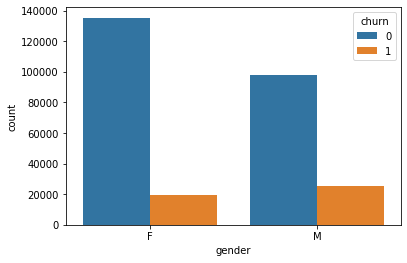

In [108]:
EDA(df,"gender")

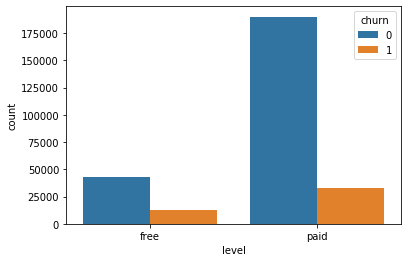

In [109]:
EDA(df,"level")

In [110]:
#change location to just get state
df = df.withColumn("location", regexp_replace("location", '[^a-zA-Z0-9\,\-]', ''))\
        .withColumn('location', split(col('location'),',').getItem(1))
df.select('location').show(n=5)

+--------+
|location|
+--------+
|      CT|
|      CT|
|      CT|
|      CT|
|      CT|
+--------+
only showing top 5 rows



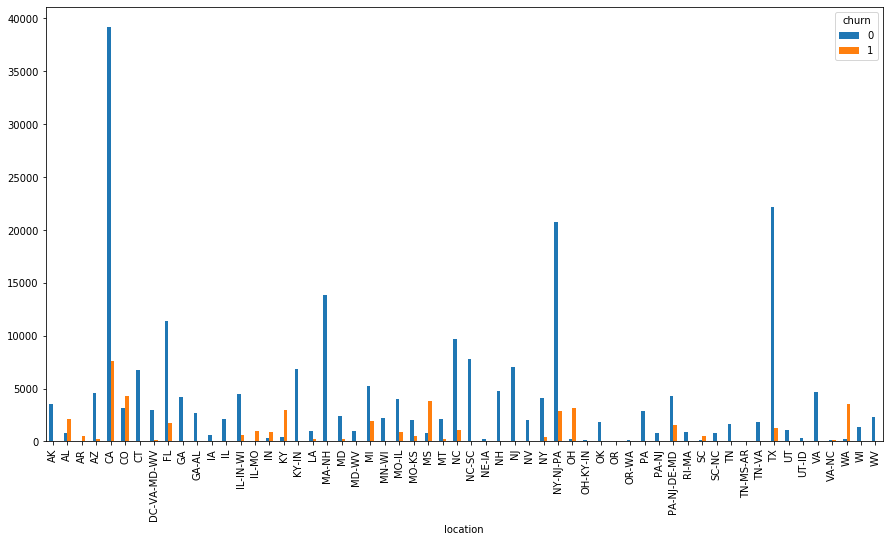

In [111]:
#EDA using location
df_state_count= df.select('userId','location','churn').groupby('location','churn').count().toPandas().sort_values(by='count')
fig = plt.figure(figsize=(15,8))
ax = fig.gca()
df_state_count.pivot(index='location', columns='churn', values='count').plot(kind='bar', ax=ax)

It is not explicitly clear if churn is dependent on location

In [112]:
#EDA using downgrade events
df.filter((col('page')=='Downgrade')&(col('churn')==1)).select('userId').distinct().count()

35

This implies that out of 52 users who churned, 35 also downgraded their service.

#### 3.1.2.2 EDA on new features which are calculated
These features are joined in a df user_churn and are engineered features.

In [113]:
user_churn = df.groupBy("userId").max("churn").withColumnRenamed("max(churn)", "churn").select(["userId", "churn"])

In [114]:
def print_boxplot(df_temp,ylabel):
    """
    prints boxplot of input col
    Input 
    df: spark DataFrame
    ylabel : column whose values are to be measured
    Output :
    None
    """
    pd_temp = user_churn.join(df_temp,["userId"]).toPandas()
    sns.boxplot(x="churn", y=ylabel, data=pd_temp);
    plt.show()

In [123]:
def count_artist(df):
    """
    Counts number of unique artists each user listens to
    Input 
    df: spark DataFrame
    Output 
    df_artist : DataFrame with artist_count
    """
    df_artist = df.groupby("userId") \
                                    .agg(countDistinct("artist")) \
                                    .withColumnRenamed("count(DISTINCT artist)", "artist_count")
    print_boxplot(df_artist,"artist_count")
    return df_artist

In [120]:
def total_visits(df):
    """
    Counts total visits of each user by counting number of times a user Id is in the dataframe
    Input 
    df: spark DataFrame
    Output 
    df_visits : DataFrame with visit_count
    """
    df_visits = df.groupby("userId") \
                                      .count() \
                                      .withColumnRenamed("count", "visit_count")
    print_boxplot(df_visits,"visit_count")
    return df_visits

In [121]:
def count_songs(df):
    """
    Counts number of unique songs each user listens to
    Input 
    df: spark DataFrame
    Output:
    df_count_songs = Dataframe with song_count
    """
    df_count_songs = df.groupby("userId")\
                                    .agg(countDistinct("song"))\
                                    .withColumnRenamed("count(DISTINCT song)", "song_count")
    print_boxplot(df_count_songs,"song_count")
    return df_count_songs

In [122]:
def total_length(df):
    """
    Sums total length of each userId
    Input 
    df: spark DataFrame
    Output 
    df_length : DataFrame with total_length
    """
    df_length = df.groupby("userId")\
                            .agg({"length" : "sum"})\
                               .withColumnRenamed("sum(length)","total_length")
    
    print_boxplot(df_length,"total_length")
    return df_length
    

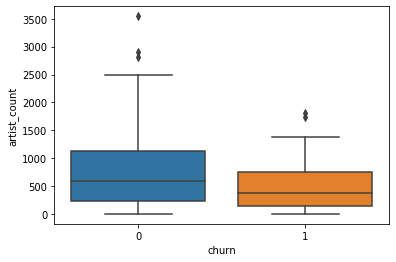

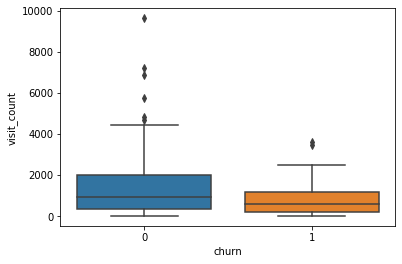

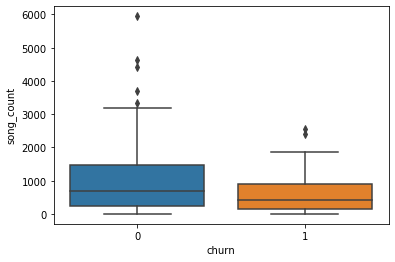

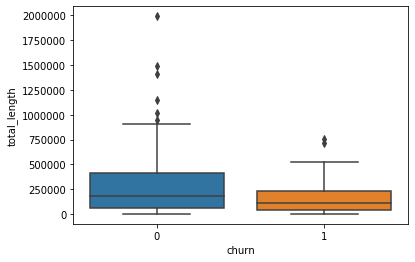

In [124]:
user_churn = user_churn.join(count_artist(df),["userId"]).join(total_visits(df),["userId"]).join(count_songs(df),["userId"])\
                        .join(total_length(df),["userId"])

In [125]:
#time related analyses 

#1. Registered days i.e time between day of registration and now

def time_features(df):
    """
    Calculates 
    1.number of days between registration(first) to last interaction
    2. Calculate number of days between last interaction and recent date.
    Input 
    df: spark DataFrame
    Output 
    df_days : DataFrame with registered_days,last_recent column
    """
    last_interaction =  df.groupBy('userId').agg(max('ts').alias('last_interaction'))

    registered_days = last_interaction.join(df, on='userId').withColumn('registered_days',\
                                                                    ((col('last_interaction')-col('registration'))/86400000)\
                                                                    .cast(IntegerType()))
    last_timestamp = df.groupby().max('ts').collect()[0]['max(ts)']
    last_recent = last_interaction.join(df, on='userId').withColumn('last_recent',\
                                                                    ((last_timestamp-col('last_interaction'))/86400000)\
                                                                    .cast(IntegerType()))
    print_boxplot(registered_days.select('userId','registered_days'),"registered_days")
    print_boxplot( last_recent.select('userId','last_recent'),"last_recent")
    
    return registered_days.select('userId','registered_days'),last_recent.select('userId','last_recent')

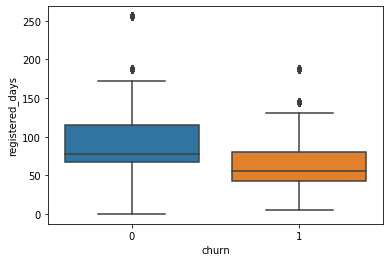

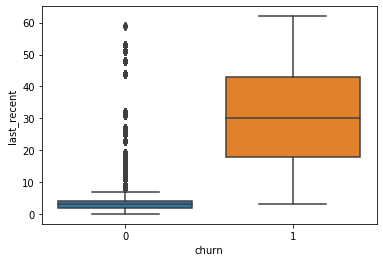

In [126]:
user_registered_days, user_last_recent = time_features(df)

In [127]:
def session_no(df):
    """
    Counts no. of sessions by sessionId
    Input 
    df: spark DataFrame
    Output 
    user_session : DataFrame with count(DISTINCT sessionId)
    """
# calculate number of sessions of each user
    user_session = df.groupby("userId").agg(countDistinct('sessionId'))
    print_boxplot(user_session,"count(DISTINCT sessionId)")
    return user_session

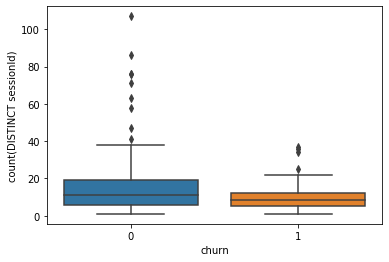

DataFrame[userId: string, count(DISTINCT sessionId): bigint]

In [128]:
session_no(df)

### Based on this analysis, the sparkify.ipynb will contain the feature engineering and modelling.